# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [107]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning & Preprocessing

In [3]:
# View the portfolio table for any issues
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The portfolio data is all visible above with no obvious issues to resolve.

In [4]:
# Determine how many records there are in the profile data
profile.shape

(17000, 5)

The profile dataset is larger and will require some more tools to clean

In [5]:
# check for missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [6]:
# check for duplicates
profile.duplicated().sum()

0

No duplicates but 2175 missing income values. These will be dropped because the income will be used as a predictor in the model for this dataset and imputing the income based on the other data available would not be useful to training the model.

In [7]:
# drop nulls and check 
profile = profile.dropna()
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [8]:
# check the new number of records 
profile.shape

(14825, 5)

In [9]:
# check for any customers under 18
profile[profile['age']<18].agg('count')

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [10]:
# check for any customers over 90
profile[profile['age']>90].agg('count')

gender              219
age                 219
id                  219
became_member_on    219
income              219
dtype: int64

In [11]:
# get the frequency distribution of the people over 90 
profile[profile['age']>90].groupby(['age']).agg('count')

,gender,id,became_member_on,income
age,,,,
91,47,47,47,47
92,40,40,40,40
93,29,29,29,29
94,33,33,33,33
95,22,22,22,22
96,8,8,8,8
97,13,13,13,13
98,5,5,5,5
99,5,5,5,5


There are a lot of customers over 90 but given the dataset has 17000 customers, 219 of them being over 90 years old is not unrealistic. Nor is it unrealistic that 5 people could be 101 years old. This information will be retained for the model 

In [12]:
# get number of records in the transcript data table
transcript.shape

(306534, 4)

In [13]:
# extract the value column which has objects in each row
values_df = transcript['value']

In [14]:
# convert the json objects in each row to a PD series
values_df = values_df.apply(pd.Series)

In [15]:
# merge the new values series to the existing table and drop the original value column
transcript_clean = pd.concat([transcript.drop('value', axis=1),values_df],axis=1)

In [16]:
# check the result
transcript_clean

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN


In [17]:
# check how many null items are in offer_id
transcript_clean['offer_id'].isna().sum()

272955

In [18]:
# the recieved offers use a different column name, offer id without the underscore.
# fill the nulls from the offer_id column with the values from offer id to merge into one row
transcript_clean['offer_id'].fillna(transcript_clean['offer id'], inplace = True)

In [19]:
# check how many nulls are in offer_id after the fill
transcript_clean['offer_id'].isna().sum()

138953

In [20]:
# drop the redundant columns 
transcript_cleaning = transcript_clean.drop(['offer id','amount','reward'], axis=1)

In [21]:
# the remaining columns are person, event, offer_id and time. 
# The remaining nulls are in the offer_id field where the event is transaction, so these rows will be dropped
transcript_cleaned = transcript_cleaning.dropna()

In [22]:
# checking the final cleaned table
transcript_cleaned

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


In [23]:
# subsets from the cleaned table will be created for received, viewed and completed offers below 

received_df = transcript_cleaned[transcript_cleaned['event']=='offer received'].sort_values(by='person')

In [24]:
viewed_df = transcript_cleaned[transcript_cleaned['event']=='offer viewed'].sort_values(by='person')

In [25]:
completed_df = transcript_cleaned[transcript_cleaned['event']=='offer completed'].sort_values(by='person')

In [26]:
# create a completed_offers field and initialise to 0. This will be the binary classifier 
completed_df['completed_offers']=0

In [27]:
# create a list of every person from the profile table
person_list = [i for i in profile['id'].unique()]

In [28]:
len(person_list)

14825

In [29]:
# some customers received the same offer more than once. Drop all but the first of each unique received offer
completed_df = completed_df.sort_values(by='time').drop_duplicates(subset=['person','offer_id']).sort_values(by='person')

In [30]:
# as above but for viewed offers
viewed_df = viewed_df.sort_values(by='time').drop_duplicates(subset=['person','offer_id']).sort_values(by='person')

In [31]:
# as above for received offers. This also includes informational offers which will not be used for modelling
received_df = received_df.sort_values(by='time').drop_duplicates(subset=['person','offer_id']).sort_values(by='person')

In [32]:
completed_df

,person,event,time,offer_id,completed_offers
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,0
228423,0009655768c64bdeb2e877511632db8f,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,0
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,0
258980,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
95422,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,0
...,...,...,...,...,...
265668,fffad4f4828548d1b5583907f2e9906b,offer completed,588,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
79668,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
143788,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,2906b810c7d4411798c6938adc9daaa5,0
214717,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0


In [33]:
# Merge the completed offers and viewed offers dataframes, preserving the completed offers rows
combined_df = pd.merge(left=completed_df, right=viewed_df, how='left', on=['person','offer_id'])

In [34]:
combined_df

,person,event_x,time_x,offer_id,completed_offers,event_y,time_y
0,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,0,offer viewed,456.0
1,0009655768c64bdeb2e877511632db8f,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,0,offer viewed,540.0
2,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,0,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,432.0
4,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,0,offer viewed,186.0
...,...,...,...,...,...,...,...
28991,fffad4f4828548d1b5583907f2e9906b,offer completed,588,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,666.0
28992,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,174.0
28993,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,2906b810c7d4411798c6938adc9daaa5,0,offer viewed,354.0
28994,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,534.0


In [35]:
# Not all customers and offer combinations are in the viewed offers data, where they are missing
# the time will be filled with a large value, 1000
combined_df['time_y'].fillna(1000)

0         456.0
1         540.0
2        1000.0
3         432.0
4         186.0
          ...  
28991     666.0
28992     174.0
28993     354.0
28994     534.0
28995       6.0
Name: time_y, Length: 28996, dtype: float64

In [36]:
# Create a new boolean array to see if the offer completed time is more than or equal to the view time
completed_offers = combined_df['time_x']>=combined_df['time_y']

In [37]:
completed_offers

0        False
1        False
2        False
3         True
4         True
         ...  
28991    False
28992     True
28993     True
28994    False
28995     True
Length: 28996, dtype: bool

In [38]:
# Convert the boolean to 0 and 1
completed_offers.map({False: 0, True:1})

0        0
1        0
2        0
3        1
4        1
        ..
28991    0
28992    1
28993    1
28994    0
28995    1
Length: 28996, dtype: int64

In [39]:
# apply the mapping to the original mapping column 
combined_df['completed_offers']=completed_offers.map({False: 0, True:1})

In [40]:
combined_df

,person,event_x,time_x,offer_id,completed_offers,event_y,time_y
0,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,0,offer viewed,456.0
1,0009655768c64bdeb2e877511632db8f,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,0,offer viewed,540.0
2,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,0,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,offer viewed,432.0
4,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,1,offer viewed,186.0
...,...,...,...,...,...,...,...
28991,fffad4f4828548d1b5583907f2e9906b,offer completed,588,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,666.0
28992,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,offer viewed,174.0
28993,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,2906b810c7d4411798c6938adc9daaa5,1,offer viewed,354.0
28994,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,534.0


In [41]:
# pivot the table to see each offer, for visualisation of the table only
combined_df.pivot(index='person', columns=['offer_id'], values=['completed_offers'])

completed_offers  \
offer_id                         0b1e1539f2cc45b7b9fa7c272da2e1d7   
person                                                              
0009655768c64bdeb2e877511632db8f                              NaN   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              0.0   
...                                                           ...   
fff29fb549084123bd046dbc5ceb4faa                              NaN   
fff3ba4757bd42088c044ca26d73817a                              NaN   
fff7576017104bcc8677a8d63322b5e1                              NaN   
fffad4f4828548d1b5583907f2e9906b                              NaN   
ffff82501cea40309d5fdd7edcca4a07                              1.0   

                                                                   \
offer_id                         2298d6c36e964ae4a3e7e9706d1fb8c2   
person                                                              
0009655768c64bdeb2e877511632db8f                              NaN   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              1.0   
003d66b6608740288d6cc97a6903f4f0                              NaN   
...                                                           ...   
fff29fb549084123bd046dbc5ceb4faa                              NaN   
fff3ba4757bd42088c044ca26d73817a                              NaN   
fff7576017104bcc8677a8d63322b5e1                              NaN   
fffad4f4828548d1b5583907f2e9906b                              NaN   
ffff82501cea40309d5fdd7edcca4a07                              NaN   

                                                                   \
offer_id                         2906b810c7d4411798c6938adc9daaa5   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              NaN   
...                                                           ...   
fff29fb549084123bd046dbc5ceb4faa                              NaN   
fff3ba4757bd42088c044ca26d73817a                              0.0   
fff7576017104bcc8677a8d63322b5e1                              NaN   
fffad4f4828548d1b5583907f2e9906b                              NaN   
ffff82501cea40309d5fdd7edcca4a07                              1.0   

                                                                   \
offer_id                         4d5c57ea9a6940dd891ad53e9dbe8da0   
person                                                              
0009655768c64bdeb2e877511632db8f                              NaN   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              1.0   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              NaN   
...                                                           ...   
fff29fb549084123bd046dbc5ceb4faa                              1.0   
fff3ba4757bd42088c044ca26d73817a                              NaN   
fff7576017104bcc8677a8d63322b5e1                              NaN   
fffad4f4828548d1b5583907f2e9906b                              NaN   
ffff82501cea40309d5fdd7edcca4a07                              NaN   

                                                                   \
offer_id                         9b98b8c7a33c4b65b9aebfe6a799e6d9   
person                                     

In [42]:
# construct a dictionary of offer type for each ID 
offer_dict = {}
for i in range(len(portfolio)):
    offer_dict[portfolio['id'].iloc[i]] = portfolio['offer_type'].iloc[i]
offer_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',
 '3f207df678b143eea3cee63160fa8bed': 'informational',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',
 'fafdcd668e3743c1bb461111dcafc2a4': 'discount',
 '5a8bc65990b245e5a138643cd4eb9837': 'informational',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',
 '2906b810c7d4411798c6938adc9daaa5': 'discount'}

In [43]:
# map the offer type based on the ID, in the combined dataframe 
combined_df['offer_id'] = combined_df['offer_id'].map(offer_dict)

In [44]:
# create an inverted flag of the completed offers, for the sorting step in the next cell
combined_df['offer_flag'] = 1-combined_df['completed_offers']

In [45]:
# sort by person, offer ID and offer flag ascending, and drop all duplicate offers. 
# the offer ascending flag will start with 0, this is where completed_offers is 1,
# thus ensuring we dont drop a completed offer is one exists
offers_df=combined_df.sort_values(by=['person','offer_id','offer_flag']).drop_duplicates(subset=['person','offer_id']).sort_values(by='person')

In [46]:
# the new table has a customer ID with one of each offer (BOGO and discount)
# pivot the table, re-insert the person ID as a column and fill NaN classes with 0
pivoted_offers = offers_df.pivot(index='person', columns=['offer_id'], values=['completed_offers'])
pivoted_offers['id'] = pivoted_offers.index
pivoted_offers = pivoted_offers.fillna(0)

In [147]:
# merge the pivoted table with the profile table for the customers we retained.
profile_offers_df = pd.merge(left = pivoted_offers, right=profile, how='right', on='id')

C:\Users\ravi_\anaconda3\envs\deep-learning\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [148]:
# check all 14,825 customers are retained with the new columns added 
profile_offers_df

,id,"(completed_offers, bogo)","(completed_offers, discount)","(id, )",gender,age,became_member_on,income
0,0610b486422d4921ae7d2bf64640c50b,0.0,0.0,0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0
1,78afa995795e4d85b5d9ceeca43f5fef,1.0,0.0,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0
2,e2127556f4f64592b11af22de27a7932,1.0,1.0,e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0
3,389bc3fa690240e798340f5a15918d5c,1.0,1.0,389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0
4,2eeac8d8feae4a8cad5a6af0499a211d,0.0,1.0,2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0
...,...,...,...,...,...,...,...,...
14820,6d5f3a774f3d4714ab0c092238f3a1d7,NaN,NaN,NaN,F,45,20180604,54000.0
14821,2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.0,2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0
14822,01d26f638c274aa0b965d24cefe3183f,NaN,NaN,NaN,M,49,20170126,73000.0
14823,9dc1421481194dcd9400aec7c9ae6366,1.0,0.0,9dc1421481194dcd9400aec7c9ae6366,F,83,20160307,50000.0


In [149]:
# rename the columns
profile_offers_df.columns = ['id','bogo','discount','id2','gender','age','became_member_on','income']

In [337]:
# construct the final dataframe, dropping the redundant columns
final_df = profile_offers_df.drop(['id2','gender','became_member_on'],axis=1)

In [338]:
# fill the remaining NaN values with 0 (for customers who didnt complete any offers)
final_df = final_df.fillna(0)

In [339]:
# save the file 
final_df.to_csv('modelling_data.csv')

## Analysis

The final_df dataframe now has the information we need for modelling. the bogo and discount classes are identified for each person by id, along with their age and income. 

In [340]:
# Load the file (if returning to this later)
final_df = pd.read_csv('modelling_data.csv')

Text(0.5, 1.0, 'Customer Age Distribution')

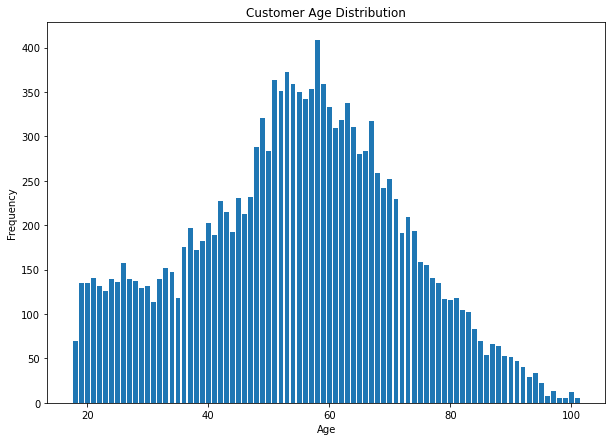

In [341]:
# Plot the freq. distribution for customer age
figure(figsize=(10,7))
plt.bar(profile.groupby('age').agg('count').index,profile.groupby('age').agg('count')['gender'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution')

Text(0.5, 1.0, 'Customer Salary Distribution')

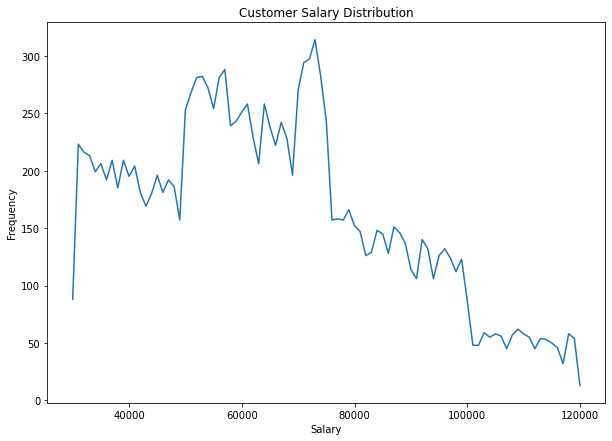

In [342]:
# plot the distribution for customer salary
figure(figsize=(10,7))
plt.plot(profile.groupby('income').agg('count').index,profile.groupby('income').agg('count')['gender'])
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Customer Salary Distribution')

In [343]:
# Summarise the statistics of each class and the proportion of data in each class

bogo1 = final_df[final_df['bogo']==1]['bogo'].agg('count')
bogo0 = final_df[final_df['bogo']==0]['bogo'].agg('count')
disc1 = final_df[final_df['discount']==1]['discount'].agg('count')
disc0 = final_df[final_df['discount']==0]['discount'].agg('count')
print('There are %d customers who viewed and completed BOGO and %d customers who did not view to complete the offer.\n\
There are %d customers who viewed and completed discount and %d customers who did not view to complete the offer. \n\
This gives us a fraction of %f and %f of BOGO and discount offers compeleted, respectively' %(bogo1,bogo0,disc1,disc0,(bogo1/(bogo1+bogo0)),(disc1/(disc1+disc0))))

There are 7166 customers who viewed and completed BOGO and 7659 customers who did not view to complete the offer.
There are 7926 customers who viewed and completed discount and 6899 customers who did not view to complete the offer. 
This gives us a fraction of 0.483373 and 0.534637 of BOGO and discount offers compeleted, respectively


Text(0, 0.5, 'Salary')

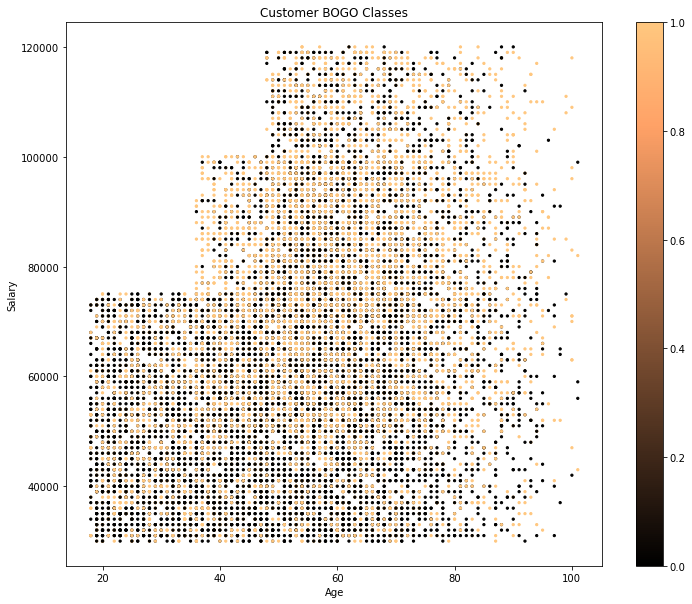

In [344]:
# plot the BOGO classes for all customers using the age and salary

figure(figsize=(12,10))
plt.scatter(final_df['age'],final_df['income'],s=5,c=final_df['bogo'],cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

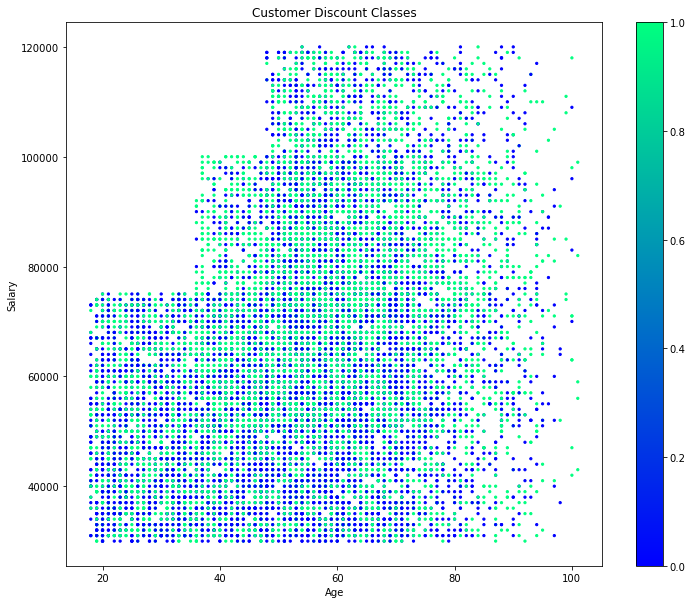

In [346]:
# plot the discount classes using age and salary

figure(figsize=(12,10))
plt.scatter(final_df['age'],final_df['income'],s=5,c=final_df['discount'],cmap='winter')
plt.colorbar()
plt.title('Customer Discount Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

## Modelling

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [390]:
# define the X and Y data from the final dataframe 
XData = final_df.drop(['id','bogo','discount'], axis=1)
#XData['gender']=XData['gender'].map({'F':0,'M':1,'O':2})
YData = final_df.drop(['id','age','income'],axis=1)

In [391]:
# Scale the X data so the salary magnitude doesn't over-influence the fitting
scaler = StandardScaler()
scaler.fit(XData)
Xscaled = scaler.transform(XData)

In [392]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xscaled, YData, test_size=0.33, random_state=42)

In [393]:
# apply a logistic regression model for both offer types, then get the predictions and print the classification report
LRmodelBOGO = LogisticRegression()
LRmodelBOGO.fit(X_train,y_train['bogo'])
LRmodelDisc = LogisticRegression()
LRmodelDisc.fit(X_train,y_train['discount'])

y_bogo_pred = LRmodelBOGO.predict(X_test)
y_disc_pred = LRmodelDisc.predict(X_test)
print(classification_report(y_test['bogo'],y_bogo_pred))
print(classification_report(y_test['discount'],y_bogo_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.66      0.62      2514
         1.0       0.58      0.49      0.53      2379

    accuracy                           0.58      4893
   macro avg       0.58      0.57      0.57      4893
weighted avg       0.58      0.58      0.57      4893

              precision    recall  f1-score   support

         0.0       0.51      0.63      0.56      2302
         1.0       0.58      0.45      0.51      2591

    accuracy                           0.54      4893
   macro avg       0.54      0.54      0.54      4893
weighted avg       0.55      0.54      0.53      4893



Text(0, 0.5, 'Salary')

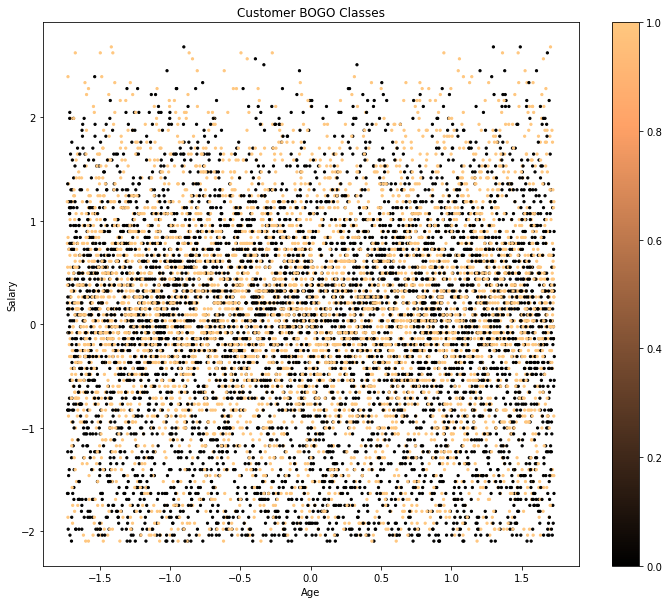

In [394]:
# plot the training classes in the new scaled X space for BOGO
figure(figsize=(12,10))
plt.scatter(X_train[:,0],X_train[:,1],s=5,c=y_train['bogo'],cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

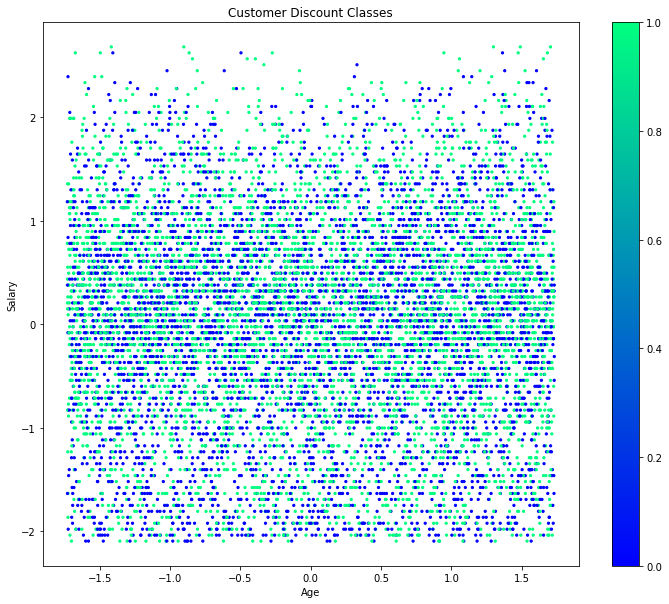

In [395]:
# plot the training classes for the new scaled X space for discounts
figure(figsize=(12,10))
plt.scatter(X_train[:,0],X_train[:,1],s=5,c=y_train['discount'],cmap='winter')
plt.colorbar()
plt.title('Customer Discount Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

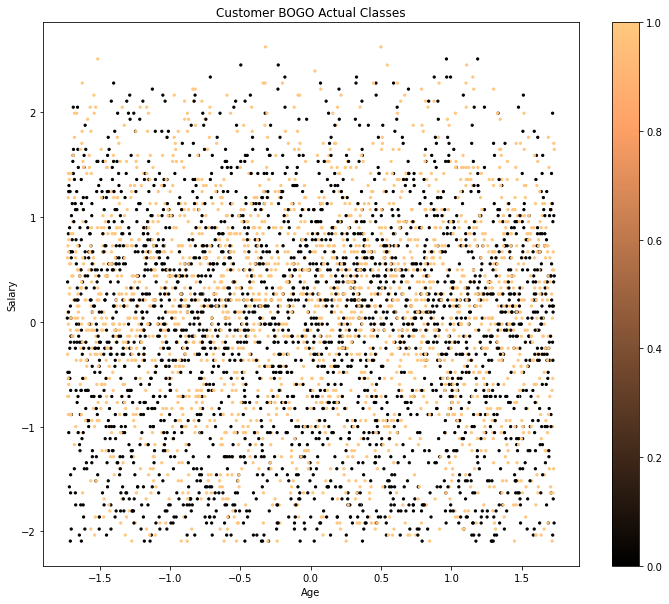

In [410]:
# plot the actual test classes for BOGO with the scaled test inputs
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_test['bogo'],cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Actual Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

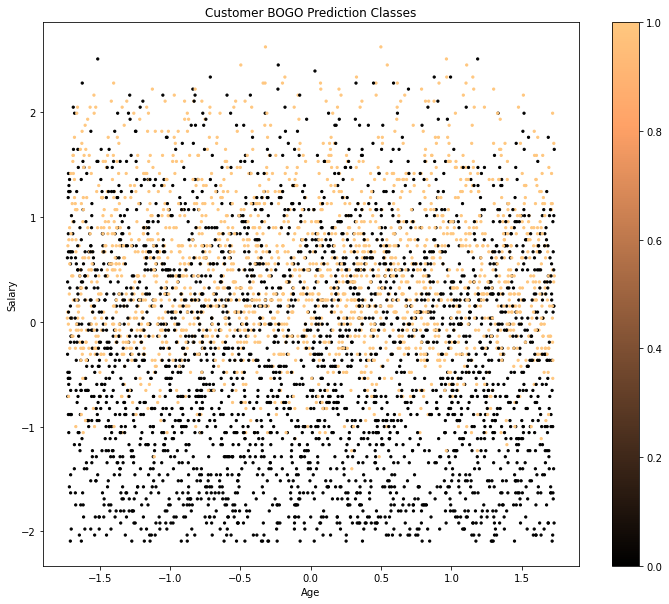

In [397]:
# plot the predicted BOGO classes from the LR model for the test input
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_bogo_pred,cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

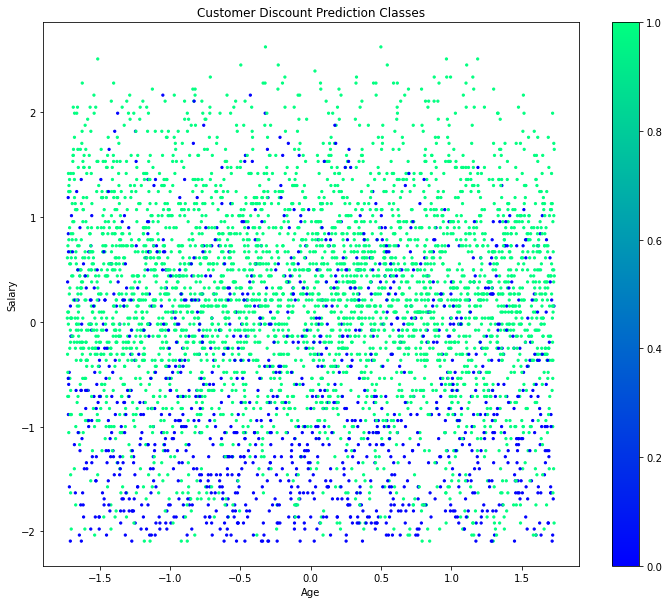

In [398]:
# Plot the LR predicted classes for discount using the test input
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_disc_pred,cmap='winter')
plt.colorbar()
plt.title('Customer Discount Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

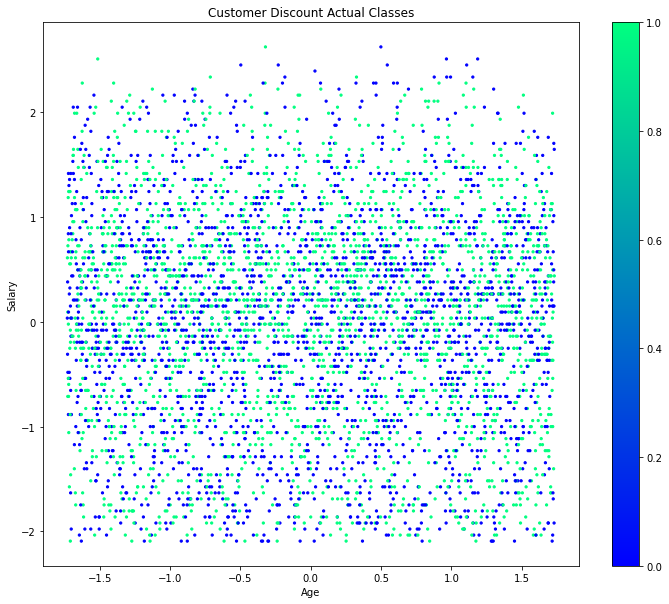

In [409]:
# plot the actual discount classes for the test data
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_test['discount'],cmap='winter')
plt.colorbar()
plt.title('Customer Discount Actual Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

In [399]:
# fit a random forest classifier with training data, then predict the classes and print report
DTmodelBOGO = RandomForestClassifier(n_estimators=200)
DTmodelBOGO.fit(X_train,y_train['bogo'])
DTmodelDisc = RandomForestClassifier(n_estimators=200)
DTmodelDisc.fit(X_train,y_train['discount'])

y_bogo_pred = DTmodelBOGO.predict(X_test)
y_disc_pred = DTmodelDisc.predict(X_test)
print(classification_report(y_test['bogo'],y_bogo_pred))
print(classification_report(y_test['discount'],y_bogo_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56      2514
         1.0       0.53      0.51      0.52      2379

    accuracy                           0.54      4893
   macro avg       0.54      0.54      0.54      4893
weighted avg       0.54      0.54      0.54      4893

              precision    recall  f1-score   support

         0.0       0.49      0.55      0.52      2302
         1.0       0.56      0.50      0.53      2591

    accuracy                           0.52      4893
   macro avg       0.53      0.53      0.52      4893
weighted avg       0.53      0.52      0.52      4893



Text(0, 0.5, 'Salary')

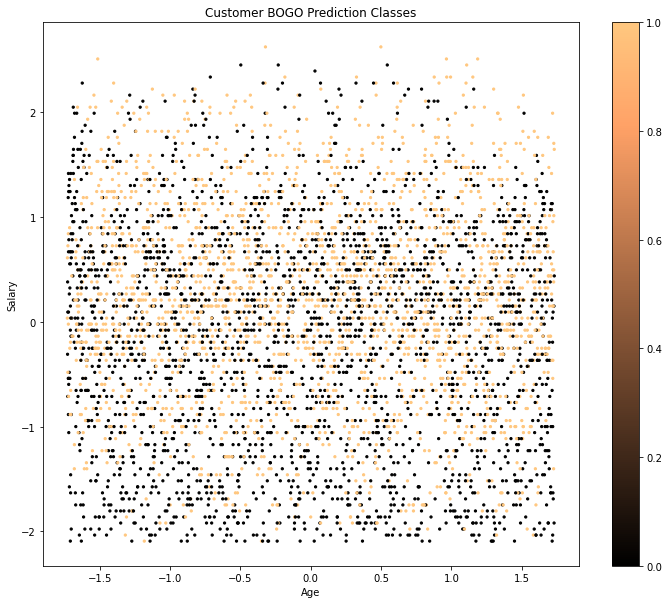

In [400]:
# random forest classifier BOGO predictions plot
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_bogo_pred,cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

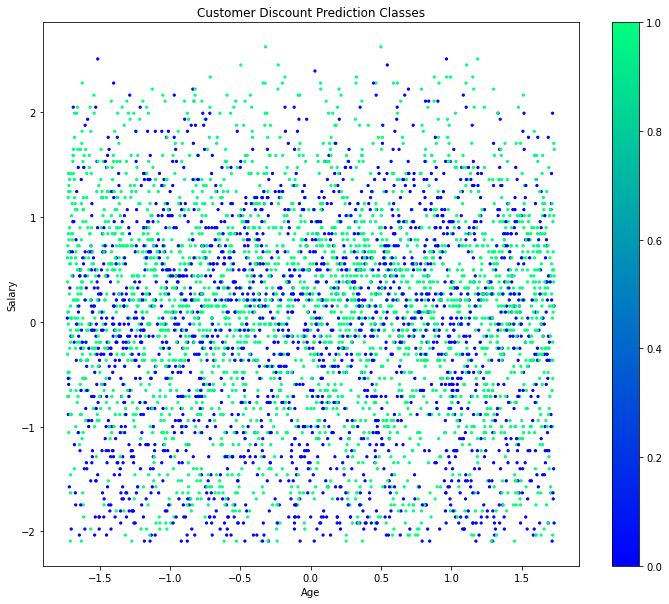

In [401]:
# random forest classifier discount predictions plot
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_disc_pred,cmap='winter')
plt.colorbar()
plt.title('Customer Discount Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

In [420]:
# as above but for the SVC models
SVCmodelBOGO = SVC(kernel='rbf')
SVCmodelBOGO.fit(X_train,y_train['bogo'])
SVCmodelDisc = SVC(kernel='rbf')
SVCmodelDisc.fit(X_train,y_train['discount'])

y_bogo_pred = SVCmodelBOGO.predict(X_test)
y_disc_pred = SVCmodelDisc.predict(X_test)
print(classification_report(y_test['bogo'],y_bogo_pred))
print(classification_report(y_test['discount'],y_bogo_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      2514
         1.0       0.57      0.56      0.57      2379

    accuracy                           0.58      4893
   macro avg       0.58      0.58      0.58      4893
weighted avg       0.58      0.58      0.58      4893

              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54      2302
         1.0       0.58      0.53      0.55      2591

    accuracy                           0.55      4893
   macro avg       0.55      0.55      0.54      4893
weighted avg       0.55      0.55      0.55      4893



Text(0, 0.5, 'Salary')

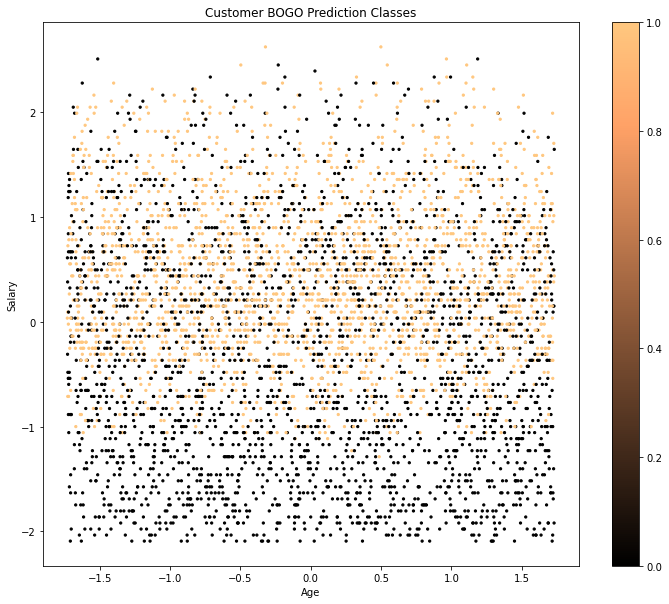

In [421]:
# SVC BOGO test data predictions 
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_bogo_pred,cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

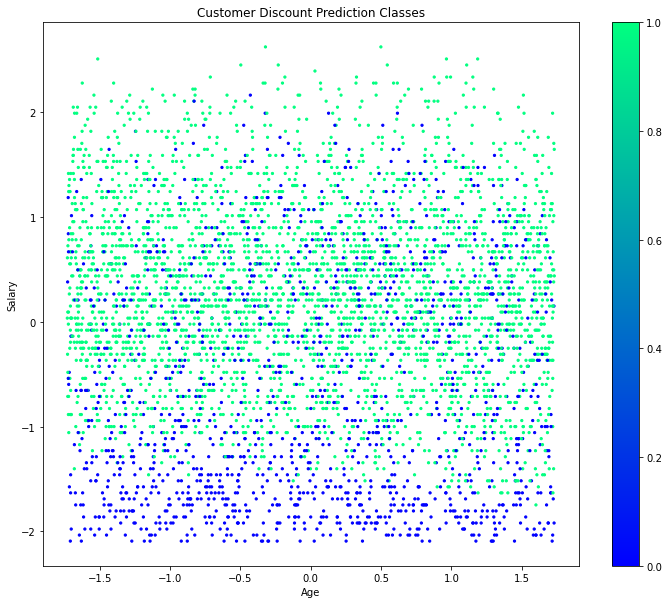

In [422]:
# SVC discount test data predictions
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_disc_pred,cmap='winter')
plt.colorbar()
plt.title('Customer Discount Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

In [405]:
# as above but for KNN
KNmodelBOGO = KNeighborsClassifier(n_neighbors=3)
KNmodelBOGO.fit(X_train,y_train['bogo'])
KNmodelDisc = KNeighborsClassifier(n_neighbors=3)
KNmodelDisc.fit(X_train,y_train['discount'])

y_bogo_pred = KNmodelBOGO.predict(X_test)
y_disc_pred = KNmodelDisc.predict(X_test)
print(classification_report(y_test['bogo'],y_bogo_pred))
print(classification_report(y_test['discount'],y_bogo_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.54      2514
         1.0       0.51      0.50      0.51      2379

    accuracy                           0.53      4893
   macro avg       0.53      0.53      0.53      4893
weighted avg       0.53      0.53      0.53      4893

              precision    recall  f1-score   support

         0.0       0.47      0.53      0.50      2302
         1.0       0.53      0.48      0.50      2591

    accuracy                           0.50      4893
   macro avg       0.50      0.50      0.50      4893
weighted avg       0.51      0.50      0.50      4893



Text(0, 0.5, 'Salary')

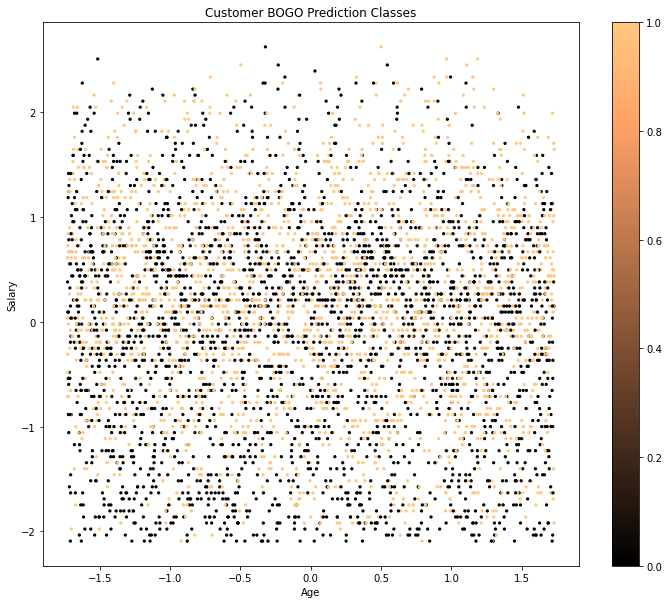

In [406]:
# KNN bogo test data predictions 
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_bogo_pred,cmap='copper')
plt.colorbar()
plt.title('Customer BOGO Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')

Text(0, 0.5, 'Salary')

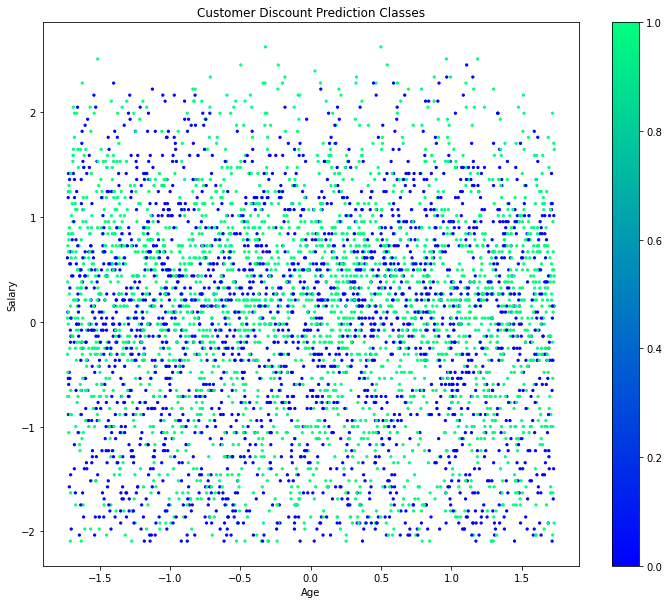

In [407]:
# KNN discount test data predictions 
figure(figsize=(12,10))
plt.scatter(X_test[:,0],X_test[:,1],s=5,c=y_disc_pred,cmap='winter')
plt.colorbar()
plt.title('Customer Discount Prediction Classes')
plt.xlabel('Age')
plt.ylabel('Salary')